### Классический ГА с зеленой волной, 150 поколений

In [8]:
import random
import numpy as np
import pandas as pd
from deap import base, creator, tools, algorithms
import json

flows = pd.read_csv("flows_peak.csv")
with open("constraints.json") as f:
    constraints = json.load(f)

NUM_INTERSECTIONS = 3
TRAVEL_TIME = 30  # seconds between crossroads
GENE_SIZE = 4  # [cycle, green_main, green_sec, offset]

def fitness(ind):
    total_delay = 0.0
    lost = 2 * constraints['lost_time_sec_per_phase']

    for i in range(NUM_INTERSECTIONS):
        base = i * GENE_SIZE
        cycle, g_main, g_sec, offset = ind[base:base+GENE_SIZE]
        # problem constraints
        if not (constraints['min_cycle_sec'] <= cycle <= constraints['max_cycle_sec']):
            return (1e9,)
        if g_main < constraints['min_green_sec'] or g_sec < constraints['min_green_sec']:
            return (1e9,)
        if g_main < constraints['pedestrian_green_sec'] or g_sec < constraints['pedestrian_green_sec']:
            return (1e9,)
        if g_main + g_sec + lost > cycle:
            return (1e9,)
        if not (0 <= offset <= cycle):
            return (1e9,)

        df = flows[flows.intersection_id == (i+1)]
        for _, row in df.iterrows():
            is_main = row.approach in ('N', 'S')
            flow = row.intensity_veh_per_hr
            bus_share = row.bus_share

            green = g_main if is_main else g_sec
            bonus = constraints['min_extra_green_sec']
            eff_green = min(cycle, green + bonus)
            # public transport priority
            weight = 1 + 2 * bus_share

            total_delay += (cycle - eff_green) * flow * weight

    penalty = 0.0
    absolute_arrival = ind[3]  

    for i in range(1, NUM_INTERSECTIONS):
        cycle_curr = ind[i * GENE_SIZE]
        offset_curr = ind[i * GENE_SIZE + 3]

        absolute_arrival += TRAVEL_TIME
        expected = absolute_arrival % cycle_curr
        diff = abs(offset_curr - expected)
        penalty += min(diff, cycle_curr - diff)

    return (total_delay + 1000 * penalty,) # penalty multiplicator



creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()


# Создание случайного индивида
def create_individual():
    genes = []
    lost = 2 * constraints['lost_time_sec_per_phase']
    for _ in range(NUM_INTERSECTIONS):
        c = random.randint(constraints['min_cycle_sec'], constraints['max_cycle_sec'])
        while True:
            g1 = random.randint(constraints['min_green_sec'], c - constraints['min_green_sec'] - lost)
            g2 = random.randint(constraints['min_green_sec'], c - constraints['min_green_sec'] - lost)
            if g1 + g2 + lost <= c:
                break
        offset = random.randint(0, c)
        genes += [c, g1, g2, offset]
    return genes

toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", fitness)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=10, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

def run():
    pop = toolbox.population(n=300)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    stats.register("avg", np.mean)

    algorithms.eaSimple(pop, toolbox,
                        cxpb=0.7, mutpb=0.3,
                        ngen=150, stats=stats,
                        halloffame=hof, verbose=True) # настройки не трогать кроме изменения количества поколений

    best = hof[0]
    print("\n=== Лучшее решение ===")
    for i in range(NUM_INTERSECTIONS):
        b = i * GENE_SIZE
        c, g1, g2, off = best[b:b+GENE_SIZE]
        print(f"Перекрёсток {i+1}: Цикл={c:.2f}, главная={g1:.2f}, второстепенная={g2:.2f}, offset={off:.2f}")
    print(f"Фитнес (задержка): {fitness(best)[0]:,.2f}")

    with open("best_solution.json", "w") as f:
        json.dump(best, f)
    return best

# Подсчёт задержки автобусов по решению
def compute_bus_delay(solution):
    bus_delay = 0.0
    for i in range(NUM_INTERSECTIONS):
        base = i * GENE_SIZE
        cycle, g_main, g_sec, offset = solution[base:base+GENE_SIZE]
        df = flows[flows.intersection_id == (i+1)]
        for _, row in df.iterrows():
            is_main = row.approach in ('N', 'S')
            flow = row.intensity_veh_per_hr
            bus_share = row.bus_share
            flow_bus = flow * bus_share
            green = g_main if is_main else g_sec
            bonus = constraints['min_extra_green_sec']
            eff_green = min(cycle, green + bonus)

            delay = (cycle - eff_green) * flow_bus
            bus_delay += delay
    return bus_delay

if __name__ == "__main__":
    best_solution = run()
    bus_only_delay = compute_bus_delay(best_solution)
    print(f"Задержка по автобусным потокам: {bus_only_delay:,.2f} машино-секунд")


c:\Users\borze\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\borze\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	min   	avg   
0  	300   	382358	751989
1  	247   	429849	6.50228e+08
2  	246   	429849	7.60154e+08
3  	236   	429849	7.50164e+08
4  	230   	429849	7.1352e+08 
5  	225   	398683	7.33507e+08
6  	243   	398683	7.13519e+08
7  	238   	398683	6.26907e+08
8  	211   	398683	5.03642e+08
9  	246   	425714	4.96969e+08
10 	235   	452263	5.06954e+08
11 	234   	398089	4.90294e+08
12 	239   	398089	4.33652e+08
13 	225   	398089	3.93667e+08
14 	231   	398089	4.13641e+08
15 	247   	398089	4.63612e+08
16 	226   	394779	3.43668e+08
17 	227   	386744	3.53652e+08
18 	247   	377230	3.76968e+08
19 	231   	376922	4.03615e+08
20 	240   	369307	3.86951e+08
21 	248   	376922	4.03609e+08
22 	234   	364203	3.33633e+08
23 	237   	340959	3.46954e+08
24 	238   	340959	2.93636e+08
25 	226   	336995	2.7697e+08 
26 	234   	336995	3.80255e+08
27 	239   	336995	4.30237e+08
28 	241   	326840	3.53599e+08
29 	222   	330206	3.50261e+08
30 	228   	328148	4.03574e+08
31 	236   	328148	4.26893e+08
32 	237   	333378	3.

## Сравнение оптимизации по времени задержки пешеходов

In [9]:
import pandas as pd
import json

signals_df = pd.read_csv("signals_current.csv")
with open("constraints.json") as f:
    constraints = json.load(f)
with open("best_solution.json") as f:
    best = json.load(f)

GENE_SIZE = 4
NUM_INTERSECTIONS = len(best) // GENE_SIZE

# План ДО оптимизации
plan_before = {
    int(row["intersection_id"]): {
        "cycle": row["cycle_sec"],
        "main": row["green_main_sec"],
        "sec": row["green_secondary_sec"]
    } for _, row in signals_df.iterrows()
}

# План ПОСЛЕ оптимизации
plan_after = {
    i + 1: {
        "cycle": best[i * GENE_SIZE],
        "main": best[i * GENE_SIZE + 1],
        "sec": best[i * GENE_SIZE + 2]
    } for i in range(NUM_INTERSECTIONS)
}

# Функция расчёта среднего времени ожидания пешеходов
def pedestrian_wait_time(plan):
    total_wait = 0
    for node in plan:
        cycle = plan[node]["cycle"]
        ped_green = min(plan[node]["main"], plan[node]["sec"])  # предположение
        wait = cycle - ped_green
        total_wait += wait
    return total_wait / len(plan)

# Расчёты и вывод
wait_before = pedestrian_wait_time(plan_before)
wait_after = pedestrian_wait_time(plan_after)

print(f"Среднее ожидание пешеходов ДО оптимизации: {wait_before:.2f} сек")
print(f"Среднее ожидание пешеходов ПОСЛЕ оптимизации: {wait_after:.2f} сек")

Среднее ожидание пешеходов ДО оптимизации: 100.00 сек
Среднее ожидание пешеходов ПОСЛЕ оптимизации: 43.89 сек


## Что было до оптимизации

In [10]:
import pandas as pd
import json

signals_df = pd.read_csv("signals_current.csv")
flows_df = pd.read_csv("flows_peak.csv")
with open("constraints.json") as f:
    constraints = json.load(f)

signal_plan_before = {}
for _, row in signals_df.iterrows():
    inter_id = int(row["intersection_id"])
    signal_plan_before[inter_id] = {
        "cycle": row["cycle_sec"],
        "main": row["green_main_sec"],
        "sec": row["green_secondary_sec"],
        "offset": 0,
        "abs_offset": 0
    }

def compute_total_delay(plan, flows, constraints):
    total = 0.0
    for inter_id, params in plan.items():
        df = flows[flows["intersection_id"] == inter_id]
        cycle = params["cycle"]
        g_main = params["main"]
        g_sec = params["sec"]
        for _, row in df.iterrows():
            is_main = row["approach"] in ["N", "S"]
            flow = row["intensity_veh_per_hr"]
            bus_share = row["bus_share"]
            green = g_main if is_main else g_sec
            bonus = constraints["min_extra_green_sec"]
            eff_green = min(cycle, green + bonus)
            weight = 1 + 2 * bus_share
            total += (cycle - eff_green) * flow * weight
    return total

def compute_bus_delay(plan, flows, constraints):
    total = 0.0
    for inter_id, params in plan.items():
        df = flows[flows["intersection_id"] == inter_id]
        cycle = params["cycle"]
        g_main = params["main"]
        g_sec = params["sec"]
        for _, row in df.iterrows():
            is_main = row["approach"] in ["N", "S"]
            flow = row["intensity_veh_per_hr"]
            bus_share = row["bus_share"]
            flow_bus = flow * bus_share
            green = g_main if is_main else g_sec
            bonus = constraints["min_extra_green_sec"]
            eff_green = min(cycle, green + bonus)
            total += (cycle - eff_green) * flow_bus
    return total

total_delay_before = compute_total_delay(signal_plan_before, flows_df, constraints)
bus_delay_before = compute_bus_delay(signal_plan_before, flows_df, constraints)

print(f"Общая задержка ДО оптимизации: {total_delay_before:,.2f} машино-сек")
print(f"Задержка по автобусам ДО оптимизации: {bus_delay_before:,.2f} машино-сек")

Общая задержка ДО оптимизации: 778,557.00 машино-сек
Задержка по автобусам ДО оптимизации: 44,028.50 машино-сек


## График фаз светофоров после оптимизации

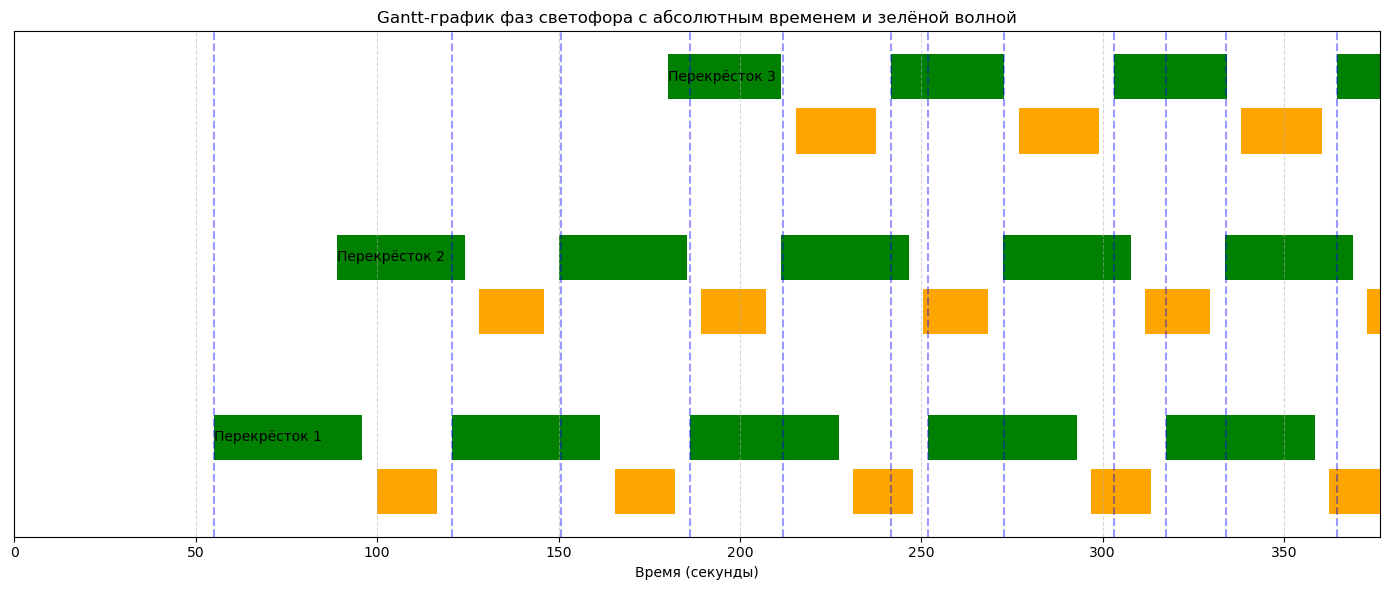

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json

signals_df = pd.read_csv("signals_current.csv")
with open("constraints.json") as f:
    constraints = json.load(f)
with open("best_solution.json") as f:
    best = json.load(f)

GENE_SIZE = 4
NUM_INTERSECTIONS = len(best) // GENE_SIZE

plan_before = {
    int(row["intersection_id"]): {
        "cycle": row["cycle_sec"],
        "main": row["green_main_sec"],
        "sec": row["green_secondary_sec"]
    } for _, row in signals_df.iterrows()
}

plan_after = {}
time_accum = 0
for i in range(NUM_INTERSECTIONS):
    cycle = best[i * GENE_SIZE]
    main = best[i * GENE_SIZE + 1]
    sec = best[i * GENE_SIZE + 2]
    # Если offset есть как параметр в solution:
    offset = best[i * GENE_SIZE + 3]
    abs_offset = time_accum + offset
    plan_after[i + 1] = {
        "cycle": cycle,
        "main": main,
        "sec": sec,
        "offset": offset,
        "abs_offset": abs_offset
    }
    time_accum += cycle

# Параметры
plot_duration = sum(p['cycle'] for p in plan_after.values()) * 2  # время отображения

fig, ax = plt.subplots(figsize=(14, 6))
colors = {"main": "green", "sec": "orange"}
TRAVEL_TIME = 30
# Вычисляем накопленное время (сумму циклов) для каждого перекрёстка
time_accumulated = 0
time_accums = []
for i in range(1, NUM_INTERSECTIONS + 1):
    if i == 1:
        time_accumulated = 0
    else:
        time_accumulated += plan_after[i - 1]['cycle']
    time_accums.append(time_accumulated)

for i, (inter_id, plan) in enumerate(plan_after.items(), start=1):
    y_main = i * 2
    y_sec = i * 2 - 0.6

    cycle = plan['cycle']
    main_dur = plan['main']
    sec_dur = plan['sec']
    lost_time = constraints['lost_time_sec_per_phase']
    abs_offset = plan['abs_offset']

    # Рисуем несколько циклов главной фазы подряд
    k = 0
    while True:
        start = abs_offset + k * cycle
        if start > plot_duration:
            break
        ax.broken_barh([(start, main_dur)], (y_main, 0.5), facecolors=colors['main'])
        k += 1

    # Аналогично второстепенная фаза (начинается после main + lost_time)
    k = 0
    while True:
        start = abs_offset + main_dur + lost_time + k * cycle
        if start > plot_duration:
            break
        ax.broken_barh([(start, sec_dur)], (y_sec, 0.5), facecolors=colors['sec'])
        k += 1

    # Рисуем линии прибытия транспорта (зелёная волна) для нескольких циклов
    # Рисуем линии прибытия транспорта (зелёная волна) для нескольких циклов
    for k in range(int(plot_duration // cycle) + 1):
        arrival = plan_after[1]['abs_offset'] + TRAVEL_TIME * (inter_id - 1) + k * cycle + time_accums[i - 1]
        ax.axvline(arrival, color='blue', linestyle='--', alpha=0.4)


    ax.text(abs_offset, y_main + 0.25, f"Перекрёсток {inter_id}", va="center")

ax.set_xlim(0, plot_duration)
ax.set_yticks([])
ax.set_xlabel("Время (секунды)")
ax.set_title("Gantt-график фаз светофора с абсолютным временем и зелёной волной")
ax.grid(True, axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


## Демонстрация нахождения оптимума в зависимости от количества поколений (лучше переделать под 5000, точку оптимума лучше выделить красным)

c:\Users\borze\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\borze\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	min   	avg   
0  	300   	401763	757565
1  	231   	433419	6.93525e+08
2  	236   	443314	7.2018e+08 
3  	232   	443499	7.30182e+08
4  	219   	443499	7.00206e+08
5  	234   	443499	6.50245e+08
6  	240   	441917	6.46914e+08
7  	244   	423253	5.60301e+08
8  	240   	459789	5.40308e+08
9  	242   	444080	4.67012e+08
10 	230   	454423	4.10368e+08
11 	239   	439156	4.37006e+08
12 	236   	436060	4.36994e+08
13 	239   	436060	4.70302e+08
14 	237   	440277	4.60299e+08
15 	225   	440277	4.53631e+08
16 	236   	420801	3.76997e+08
17 	231   	411640	3.8698e+08 
18 	236   	411640	3.43661e+08
19 	241   	405234	3.96961e+08
20 	226   	405234	3.56977e+08
21 	237   	393933	3.60301e+08
22 	245   	381333	3.96949e+08
23 	234   	381333	3.30311e+08
24 	232   	386504	3.50297e+08
25 	241   	384351	4.13596e+08
26 	243   	379781	3.60286e+08
27 	240   	365753	3.8694e+08 
28 	230   	375909	2.90314e+08
29 	241   	375909	3.86936e+08
30 	229   	378969	3.6028e+08 
31 	235   	383378	3.70275e+08
32 	255   	368668	4.

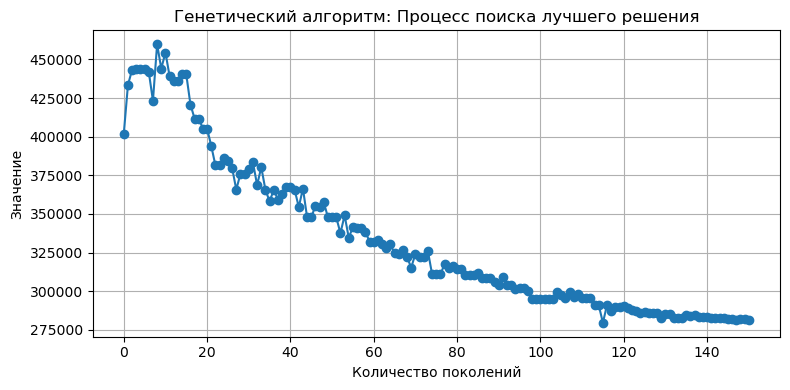

In [12]:
import random
import numpy as np
import pandas as pd
from deap import base, creator, tools, algorithms
import json
import matplotlib.pyplot as plt


flows = pd.read_csv("flows_peak.csv")
with open("constraints.json") as f:
    constraints = json.load(f)


NUM_INTERSECTIONS = 3
TRAVEL_TIME = 30  # секунд между перекрёстками
GENE_SIZE = 4  # [cycle, green_main, green_sec, offset]


def fitness(ind):
    total_delay = 0.0
    lost = 2 * constraints['lost_time_sec_per_phase']

    for i in range(NUM_INTERSECTIONS):
        base = i * GENE_SIZE
        cycle, g_main, g_sec, offset = ind[base:base+GENE_SIZE]

        # Проверка ограничений
        if not (constraints['min_cycle_sec'] <= cycle <= constraints['max_cycle_sec']):
            return (1e9,)
        if g_main < constraints['min_green_sec'] or g_sec < constraints['min_green_sec']:
            return (1e9,)
        if g_main < constraints['pedestrian_green_sec'] or g_sec < constraints['pedestrian_green_sec']:
            return (1e9,)
        if g_main + g_sec + lost > cycle:
            return (1e9,)
        if not (0 <= offset <= cycle):
            return (1e9,)

        # Задержка по всем потокам с приоритетом автобусов
        df = flows[flows.intersection_id == (i+1)]
        for _, row in df.iterrows():
            is_main = row.approach in ('N', 'S')
            flow = row.intensity_veh_per_hr
            bus_share = row.bus_share

            green = g_main if is_main else g_sec
            bonus = constraints['min_extra_green_sec']
            eff_green = min(cycle, green + bonus)
            weight = 1 + 2 * bus_share

            total_delay += (cycle - eff_green) * flow * weight

    # Координация (зелёная волна) с умеренным штрафом
    penalty = 0.0
    absolute_arrival = ind[3]  # offset первого перекрёстка

    for i in range(1, NUM_INTERSECTIONS):
        cycle_curr = ind[i * GENE_SIZE]
        offset_curr = ind[i * GENE_SIZE + 3]

        absolute_arrival += TRAVEL_TIME
        expected = absolute_arrival % cycle_curr
        diff = abs(offset_curr - expected)
        penalty += min(diff, cycle_curr - diff)

    return (total_delay + 1000 * penalty,)

# === Инициализация DEAP ===
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()

# Создание случайного индивида
def create_individual():
    genes = []
    lost = 2 * constraints['lost_time_sec_per_phase']
    for _ in range(NUM_INTERSECTIONS):
        c = random.randint(constraints['min_cycle_sec'], constraints['max_cycle_sec'])
        while True:
            g1 = random.randint(constraints['min_green_sec'], c - constraints['min_green_sec'] - lost)
            g2 = random.randint(constraints['min_green_sec'], c - constraints['min_green_sec'] - lost)
            if g1 + g2 + lost <= c:
                break
        offset = random.randint(0, c)
        genes += [c, g1, g2, offset]
    return genes

toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", fitness)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=10, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)


def run_with_stats():
    pop = toolbox.population(n=300)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    stats.register("avg", np.mean)

    _, logbook = algorithms.eaSimple(pop, toolbox,
                        cxpb=0.7, mutpb=0.3,
                        ngen=150, stats=stats,
                        halloffame=hof, verbose=True)

    best = hof[0]
    print("\n=== Лучшее решение ===")
    for i in range(NUM_INTERSECTIONS):
        b = i * GENE_SIZE
        c, g1, g2, off = best[b:b+GENE_SIZE]
        print(f"Перекрёсток {i+1}: Цикл={c:.2f}, главная={g1:.2f}, второстепенная={g2:.2f}, offset={off:.2f}")
    print(f"Фитнес (задержка): {fitness(best)[0]:,.2f}")

    with open("best_solution.json", "w") as f:
        json.dump(best, f)

    return logbook

logbook = run_with_stats()

gens = logbook.select("gen")       # список поколений [0, 1, 2, …]
best_vals = logbook.select("min")  # лучшая (минимальная) ценность фитнеса на каждом поколении

plt.figure(figsize=(8, 4))
plt.plot(gens, best_vals, marker="o", linestyle="-")
plt.title("Генетический алгоритм: Процесс поиска лучшего решения")
plt.xlabel("Количество поколений")
plt.ylabel("Значение")
plt.grid(True)
plt.tight_layout()
plt.show()


### Генетический алгоритм на 5000 поколений с добавленными ГОСТами

In [13]:
import random
import numpy as np
import pandas as pd
from deap import base, creator, tools, algorithms
import json


flows = pd.read_csv("flows_peak.csv")
with open("constraints.json") as f:
    constraints = json.load(f)

In [14]:
# === ГОСТОВЫЕ "захардкоженные" параметры ===
TYPICAL_LANES_MAIN = 2  # Главная дорога: 2 полосы
TYPICAL_LANES_SEC = 1   # Второстепенная: 1 полоса
LANE_WIDTH = 3.5        # м
ROAD_WIDTH_MAIN = TYPICAL_LANES_MAIN * LANE_WIDTH
ROAD_WIDTH_SEC = TYPICAL_LANES_SEC * LANE_WIDTH
PEDESTRIAN_SPEED = 1.3  # м/с (ГОСТ)
LOST_TIME = constraints['lost_time_sec_per_phase']  # Уже есть в данных
MIN_CYCLE = constraints['min_cycle_sec']
MAX_CYCLE = constraints['max_cycle_sec']
MIN_GREEN = constraints['min_green_sec']

# Время для пешехода (по главной и второстепенной)
PEDESTRIAN_GREEN_MAIN = 5 + ROAD_WIDTH_MAIN / PEDESTRIAN_SPEED   # ~10.4 сек
PEDESTRIAN_GREEN_SEC = 5 + ROAD_WIDTH_SEC / PEDESTRIAN_SPEED     # ~7.7 сек

NUM_INTERSECTIONS = 3
TRAVEL_TIME = 30  # секунд между перекрёстками
GENE_SIZE = 4  # [cycle, green_main, green_sec, offset]

c:\Users\borze\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\borze\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	min   	avg   
0  	300   	327373	751703
1  	240   	327373	6.56884e+08
2  	248   	343224	7.16854e+08
3  	209   	334369	6.70218e+08
4  	256   	389272	7.0686e+08 
5  	212   	389272	6.7022e+08 
6  	241   	397090	6.66888e+08
7  	236   	355962	6.83543e+08
8  	232   	444481	5.73619e+08
9  	235   	415242	5.33638e+08
10 	243   	415242	5.16981e+08
11 	228   	415242	5.10304e+08
12 	228   	415242	4.86977e+08
13 	242   	443830	4.07017e+08
14 	210   	433649	3.70361e+08
15 	233   	433649	3.93668e+08
16 	239   	409483	4.16979e+08
17 	223   	408347	4.16973e+08
18 	248   	403576	5.00261e+08
19 	237   	415487	4.80272e+08
20 	241   	415487	4.5695e+08 
21 	245   	415487	4.56949e+08
22 	237   	410360	4.56942e+08
23 	245   	386690	4.26953e+08
24 	226   	378622	3.83632e+08
25 	231   	378622	3.86959e+08
26 	236   	377134	4.16937e+08
27 	246   	378424	4.4359e+08 
28 	230   	378622	4.16933e+08
29 	241   	343520	4.2026e+08 
30 	243   	343520	4.4025e+08 
31 	244   	350942	4.36918e+08
32 	225   	369627	4.

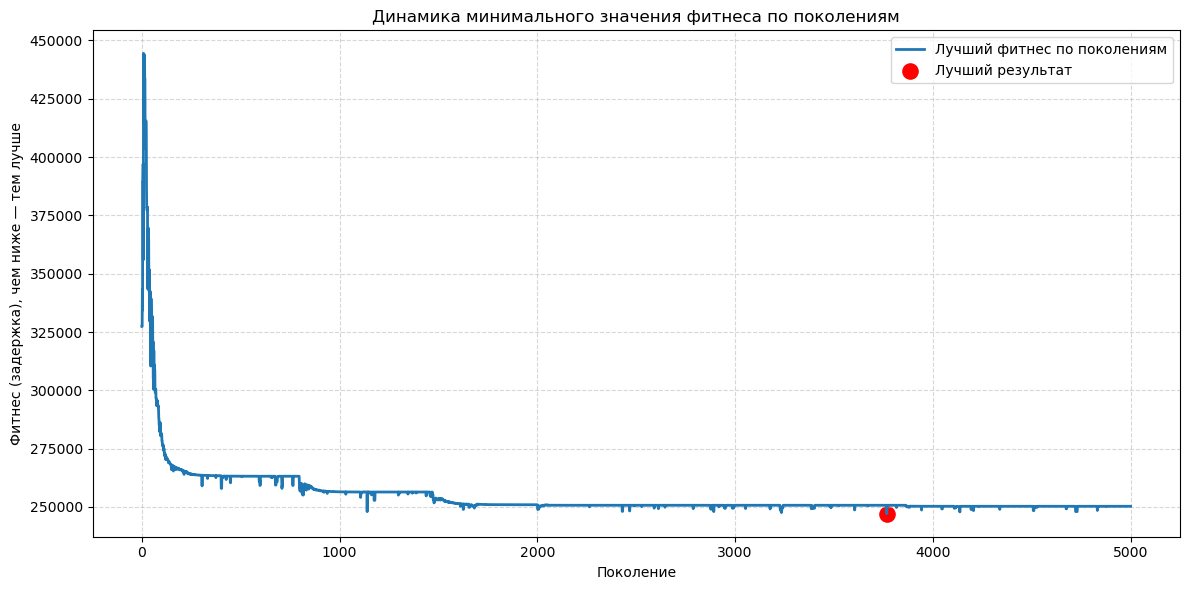

Задержка по автобусным потокам: 12,150.06 машино-секунд
Лучший результат достигнут на 3767-м поколении.
Значение функции задержки: 247,096.88


In [15]:
# === Фитнес-функция с ГОСТ-проверками ===
def fitness(ind):
    total_delay = 0.0
    lost = 2 * LOST_TIME

    for i in range(NUM_INTERSECTIONS):
        base = i * GENE_SIZE
        cycle, g_main, g_sec, offset = ind[base:base+GENE_SIZE]

        # 1. Проверка по ГОСТ: цикл
        if not (MIN_CYCLE <= cycle <= MAX_CYCLE):
            return (1e9,)
        # 2. Минимальные фазы для транспорта
        if g_main < MIN_GREEN or g_sec < MIN_GREEN:
            return (1e9,)
        # 3. Минимальная длительность пешеходной фазы по ГОСТ (типовая геометрия!)
        if g_main < PEDESTRIAN_GREEN_MAIN or g_sec < PEDESTRIAN_GREEN_SEC:
            return (1e9,)
        # 4. Сумма фаз и потерь не превышает цикл
        if g_main + g_sec + lost > cycle:
            return (1e9,)
        # 5. Смещение offset в допустимых границах
        if not (0 <= offset <= cycle):
            return (1e9,)

        # === Считаем задержку потоков ===
        df = flows[flows.intersection_id == (i+1)]
        for _, row in df.iterrows():
            is_main = row.approach in ('N', 'S')
            flow = row.intensity_veh_per_hr
            bus_share = row.bus_share

            green = g_main if is_main else g_sec
            bonus = constraints['min_extra_green_sec']
            eff_green = min(cycle, green + bonus)
            weight = 1 + 2 * bus_share  # приоритет для автобусов

            total_delay += (cycle - eff_green) * flow * weight

    # === Штраф за рассинхронизацию "зелёной волны" ===
    penalty = 0.0
    absolute_arrival = ind[3]  # offset первого перекрёстка

    for i in range(1, NUM_INTERSECTIONS):
        cycle_curr = ind[i * GENE_SIZE]
        offset_curr = ind[i * GENE_SIZE + 3]

        absolute_arrival += TRAVEL_TIME
        expected = absolute_arrival % cycle_curr
        diff = abs(offset_curr - expected)
        penalty += min(diff, cycle_curr - diff)

    return (total_delay + 1000 * penalty,)

# === Инициализация DEAP ===
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()

# Создание случайного индивида
def create_individual():
    genes = []
    lost = 2 * LOST_TIME
    for idx in range(NUM_INTERSECTIONS):
        c = random.randint(MIN_CYCLE, MAX_CYCLE)
        while True:
            g1 = random.randint(MIN_GREEN, c - MIN_GREEN - lost)
            g2 = random.randint(MIN_GREEN, c - MIN_GREEN - lost)
            # Учитываем пешеходные ГОСТ-ограничения!
            if (g1 >= PEDESTRIAN_GREEN_MAIN and g2 >= PEDESTRIAN_GREEN_SEC and g1 + g2 + lost <= c):
                break
        offset = random.randint(0, c)
        genes += [c, g1, g2, offset]
    return genes

toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", fitness)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=10, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# === Запуск оптимизации ===
def run():
    pop = toolbox.population(n=300)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    stats.register("avg", np.mean)

    # algorithms.eaSimple возвращает (population, logbook)
    pop, logbook = algorithms.eaSimple(pop, toolbox,
                                       cxpb=0.7, mutpb=0.3,
                                       ngen=5000, stats=stats,
                                       halloffame=hof, verbose=True)

    best = hof[0]
    print("\n=== Лучшее решение ===")
    for i in range(NUM_INTERSECTIONS):
        b = i * GENE_SIZE
        c, g1, g2, off = best[b:b+GENE_SIZE]
        print(f"Перекрёсток {i+1}: Цикл={c:.2f}, главная={g1:.2f}, второстепенная={g2:.2f}, offset={off:.2f}")
    print(f"Фитнес (задержка): {fitness(best)[0]:,.2f}")

    with open("best_solution.json", "w") as f:
        json.dump(best, f)

    return best, logbook

# Подсчёт задержки автобусов по решению
def compute_bus_delay(solution):
    bus_delay = 0.0
    for i in range(NUM_INTERSECTIONS):
        base = i * GENE_SIZE
        cycle, g_main, g_sec, offset = solution[base:base+GENE_SIZE]
        df = flows[flows.intersection_id == (i+1)]
        for _, row in df.iterrows():
            is_main = row.approach in ('N', 'S')
            flow = row.intensity_veh_per_hr
            bus_share = row.bus_share
            flow_bus = flow * bus_share
            green = g_main if is_main else g_sec
            bonus = constraints['min_extra_green_sec']
            eff_green = min(cycle, green + bonus)

            delay = (cycle - eff_green) * flow_bus
            bus_delay += delay
    return bus_delay


if __name__ == "__main__":
    best_solution, logbook = run()
    min_history = logbook.select("min")
    generations = np.arange(len(min_history))
    min_value = np.min(min_history)
    min_index = np.argmin(min_history)

    plt.figure(figsize=(12, 6))
    plt.plot(generations, min_history, label='Лучший фитнес по поколениям', lw=2)
    plt.scatter([min_index], [min_value], color='red', s=120, marker='o', label='Лучший результат')
    plt.title("Динамика минимального значения фитнеса по поколениям")
    plt.xlabel("Поколение")
    plt.ylabel("Фитнес (задержка), чем ниже — тем лучше")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    bus_only_delay = compute_bus_delay(best_solution)
    print(f"Задержка по автобусным потокам: {bus_only_delay:,.2f} машино-секунд")
    print(f"Лучший результат достигнут на {min_index}-м поколении.")
    print(f"Значение функции задержки: {min_value:,.2f}")


## График фаз светофоров в обновленном ГА

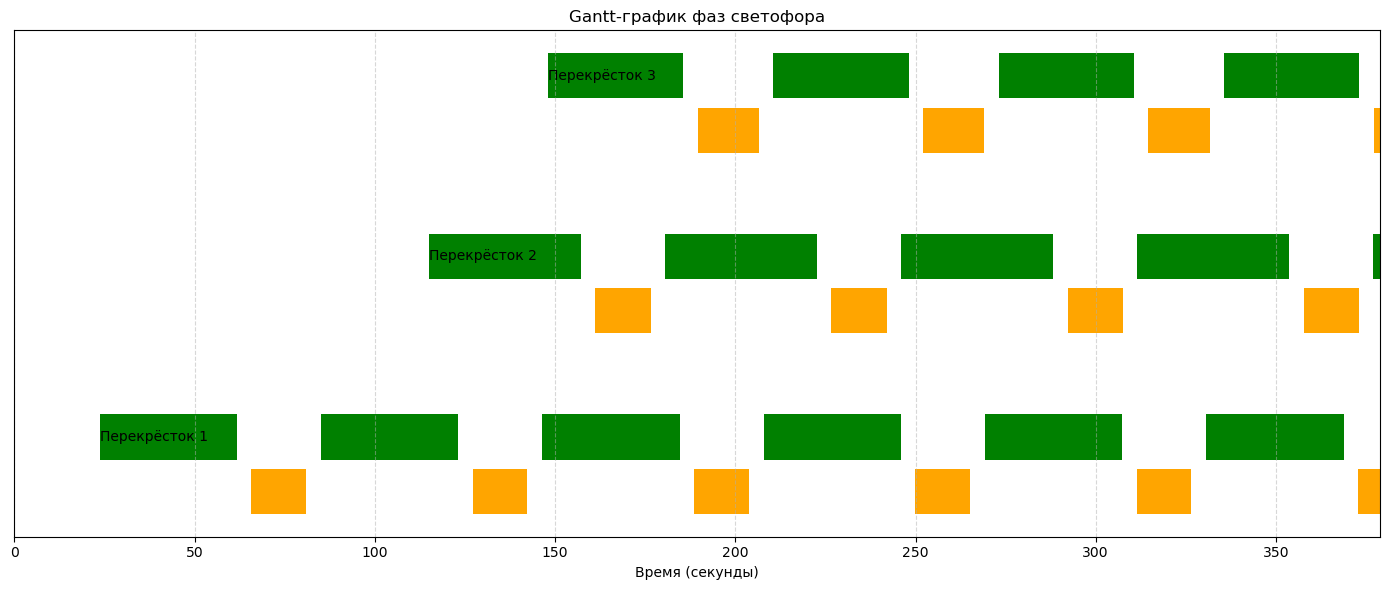

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json


signals_df = pd.read_csv("signals_current.csv")
with open("constraints.json") as f:
    constraints = json.load(f)
with open("best_solution.json") as f:
    best = json.load(f)

GENE_SIZE = 4
NUM_INTERSECTIONS = len(best) // GENE_SIZE

# План ПОСЛЕ оптимизации с abs_offset
plan_after = {}
time_accum = 0
for i in range(NUM_INTERSECTIONS):
    cycle = best[i * GENE_SIZE]
    main = best[i * GENE_SIZE + 1]
    sec = best[i * GENE_SIZE + 2]
    offset = best[i * GENE_SIZE + 3]
    abs_offset = time_accum + offset
    plan_after[i + 1] = {
        "cycle": cycle,
        "main": main,
        "sec": sec,
        "offset": offset,
        "abs_offset": abs_offset
    }
    time_accum += cycle

# === ВИЗУАЛИЗАЦИЯ ===
plot_duration = sum(p['cycle'] for p in plan_after.values()) * 2

fig, ax = plt.subplots(figsize=(14, 6))
colors = {"main": "green", "sec": "orange"}

for i, (inter_id, plan) in enumerate(plan_after.items(), start=1):
    y_main = i * 2
    y_sec = i * 2 - 0.6

    cycle = plan['cycle']
    main_dur = plan['main']
    sec_dur = plan['sec']
    lost_time = constraints['lost_time_sec_per_phase']
    abs_offset = plan['abs_offset']

    # Главная фаза (несколько повторов)
    k = 0
    while True:
        start = abs_offset + k * cycle
        if start > plot_duration:
            break
        ax.broken_barh([(start, main_dur)], (y_main, 0.5), facecolors=colors['main'])
        k += 1

    # Второстепенная фаза (несколько повторов)
    k = 0
    while True:
        start = abs_offset + main_dur + lost_time + k * cycle
        if start > plot_duration:
            break
        ax.broken_barh([(start, sec_dur)], (y_sec, 0.5), facecolors=colors['sec'])
        k += 1

    ax.text(abs_offset, y_main + 0.25, f"Перекрёсток {inter_id}", va="center")

ax.set_xlim(0, plot_duration)
ax.set_yticks([])
ax.set_xlabel("Время (секунды)")
ax.set_title("Gantt-график фаз светофора")
ax.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## Генетический алгоритм на 10000 поколений с учетом ГОСТов

c:\Users\borze\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\borze\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	min   	avg   
0  	300   	373328	750662
1  	229   	406003	6.03585e+08
2  	246   	406003	7.60158e+08
3  	234   	396599	7.36837e+08
4  	251   	396599	7.16861e+08
5  	230   	419492	7.03542e+08
6  	233   	401186	6.86888e+08
7  	250   	378060	6.53579e+08
8  	233   	416846	5.9028e+08 
9  	239   	416846	5.90278e+08
10 	230   	416846	6.00258e+08
11 	244   	416846	4.93656e+08
12 	251   	417145	5.5028e+08 
13 	244   	417145	4.96976e+08
14 	230   	417145	4.60323e+08
15 	238   	436636	4.70307e+08
16 	241   	430563	5.00277e+08
17 	242   	399388	5.00272e+08
18 	245   	400452	4.50297e+08
19 	230   	411262	4.43629e+08
20 	248   	387587	4.40294e+08
21 	236   	418868	4.13637e+08
22 	226   	403304	3.20341e+08
23 	235   	394765	3.43653e+08
24 	239   	385842	4.00286e+08
25 	237   	385045	3.9362e+08 
26 	246   	369056	3.96947e+08
27 	226   	356577	3.93607e+08
28 	227   	369981	4.0693e+08 
29 	232   	359671	3.36956e+08
30 	227   	368164	3.5361e+08 
31 	239   	338112	3.86927e+08
32 	234   	332705	3.

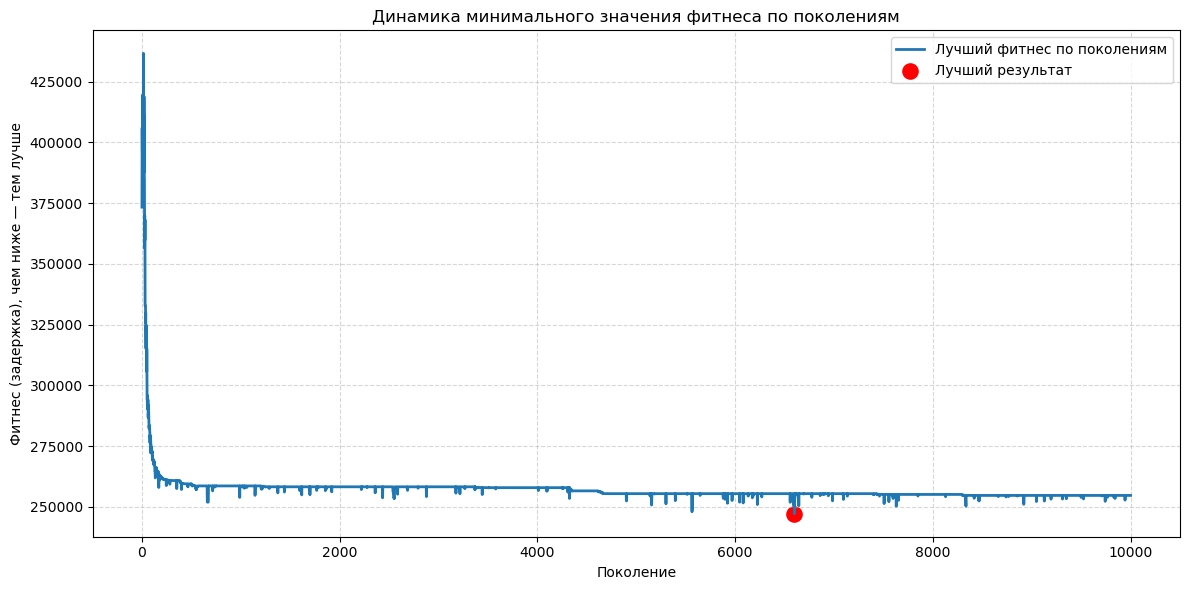

Задержка по автобусным потокам: 12,197.72 машино-секунд
Лучший результат достигнут на 6600-м поколении.
Значение функции задержки: 247,183.59


In [17]:
# === Фитнес-функция с ГОСТ-проверками ===
def fitness(ind):
    total_delay = 0.0
    lost = 2 * LOST_TIME

    for i in range(NUM_INTERSECTIONS):
        base = i * GENE_SIZE
        cycle, g_main, g_sec, offset = ind[base:base+GENE_SIZE]

        # 1. Проверка по ГОСТ: цикл
        if not (MIN_CYCLE <= cycle <= MAX_CYCLE):
            return (1e9,)
        # 2. Минимальные фазы для транспорта
        if g_main < MIN_GREEN or g_sec < MIN_GREEN:
            return (1e9,)
        # 3. Минимальная длительность пешеходной фазы по ГОСТ (типовая геометрия!)
        if g_main < PEDESTRIAN_GREEN_MAIN or g_sec < PEDESTRIAN_GREEN_SEC:
            return (1e9,)
        # 4. Сумма фаз и потерь не превышает цикл
        if g_main + g_sec + lost > cycle:
            return (1e9,)
        # 5. Смещение offset в допустимых границах
        if not (0 <= offset <= cycle):
            return (1e9,)

        # === Считаем задержку потоков ===
        df = flows[flows.intersection_id == (i+1)]
        for _, row in df.iterrows():
            is_main = row.approach in ('N', 'S')
            flow = row.intensity_veh_per_hr
            bus_share = row.bus_share

            green = g_main if is_main else g_sec
            bonus = constraints['min_extra_green_sec']
            eff_green = min(cycle, green + bonus)
            weight = 1 + 2 * bus_share  # приоритет для автобусов

            total_delay += (cycle - eff_green) * flow * weight

    # === Штраф за рассинхронизацию "зелёной волны" ===
    penalty = 0.0
    absolute_arrival = ind[3]  # offset первого перекрёстка

    for i in range(1, NUM_INTERSECTIONS):
        cycle_curr = ind[i * GENE_SIZE]
        offset_curr = ind[i * GENE_SIZE + 3]

        absolute_arrival += TRAVEL_TIME
        expected = absolute_arrival % cycle_curr
        diff = abs(offset_curr - expected)
        penalty += min(diff, cycle_curr - diff)

    return (total_delay + 1000 * penalty,)

# === Инициализация DEAP ===
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()

# Создание случайного индивида
def create_individual():
    genes = []
    lost = 2 * LOST_TIME
    for idx in range(NUM_INTERSECTIONS):
        c = random.randint(MIN_CYCLE, MAX_CYCLE)
        while True:
            g1 = random.randint(MIN_GREEN, c - MIN_GREEN - lost)
            g2 = random.randint(MIN_GREEN, c - MIN_GREEN - lost)
            # Учитываем пешеходные ГОСТ-ограничения!
            if (g1 >= PEDESTRIAN_GREEN_MAIN and g2 >= PEDESTRIAN_GREEN_SEC and g1 + g2 + lost <= c):
                break
        offset = random.randint(0, c)
        genes += [c, g1, g2, offset]
    return genes

toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", fitness)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=10, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# === Запуск оптимизации ===
def run():
    pop = toolbox.population(n=300)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    stats.register("avg", np.mean)

    # algorithms.eaSimple возвращает (population, logbook)
    pop, logbook = algorithms.eaSimple(pop, toolbox,
                                       cxpb=0.7, mutpb=0.3,
                                       ngen=10000, stats=stats,
                                       halloffame=hof, verbose=True)

    best = hof[0]
    print("\n=== Лучшее решение ===")
    for i in range(NUM_INTERSECTIONS):
        b = i * GENE_SIZE
        c, g1, g2, off = best[b:b+GENE_SIZE]
        print(f"Перекрёсток {i+1}: Цикл={c:.2f}, главная={g1:.2f}, второстепенная={g2:.2f}, offset={off:.2f}")
    print(f"Фитнес (задержка): {fitness(best)[0]:,.2f}")

    with open("best_solution.json", "w") as f:
        json.dump(best, f)

    return best, logbook

# Подсчёт задержки автобусов по решению
def compute_bus_delay(solution):
    bus_delay = 0.0
    for i in range(NUM_INTERSECTIONS):
        base = i * GENE_SIZE
        cycle, g_main, g_sec, offset = solution[base:base+GENE_SIZE]
        df = flows[flows.intersection_id == (i+1)]
        for _, row in df.iterrows():
            is_main = row.approach in ('N', 'S')
            flow = row.intensity_veh_per_hr
            bus_share = row.bus_share
            flow_bus = flow * bus_share
            green = g_main if is_main else g_sec
            bonus = constraints['min_extra_green_sec']
            eff_green = min(cycle, green + bonus)

            delay = (cycle - eff_green) * flow_bus
            bus_delay += delay
    return bus_delay


if __name__ == "__main__":
    best_solution, logbook = run()
    min_history = logbook.select("min")
    generations = np.arange(len(min_history))
    min_value = np.min(min_history)
    min_index = np.argmin(min_history)

    plt.figure(figsize=(12, 6))
    plt.plot(generations, min_history, label='Лучший фитнес по поколениям', lw=2)
    plt.scatter([min_index], [min_value], color='red', s=120, marker='o', label='Лучший результат')
    plt.title("Динамика минимального значения фитнеса по поколениям")
    plt.xlabel("Поколение")
    plt.ylabel("Фитнес (задержка), чем ниже — тем лучше")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    bus_only_delay = compute_bus_delay(best_solution)
    print(f"Задержка по автобусным потокам: {bus_only_delay:,.2f} машино-секунд")
    print(f"Лучший результат достигнут на {min_index}-м поколении.")
    print(f"Значение функции задержки: {min_value:,.2f}")

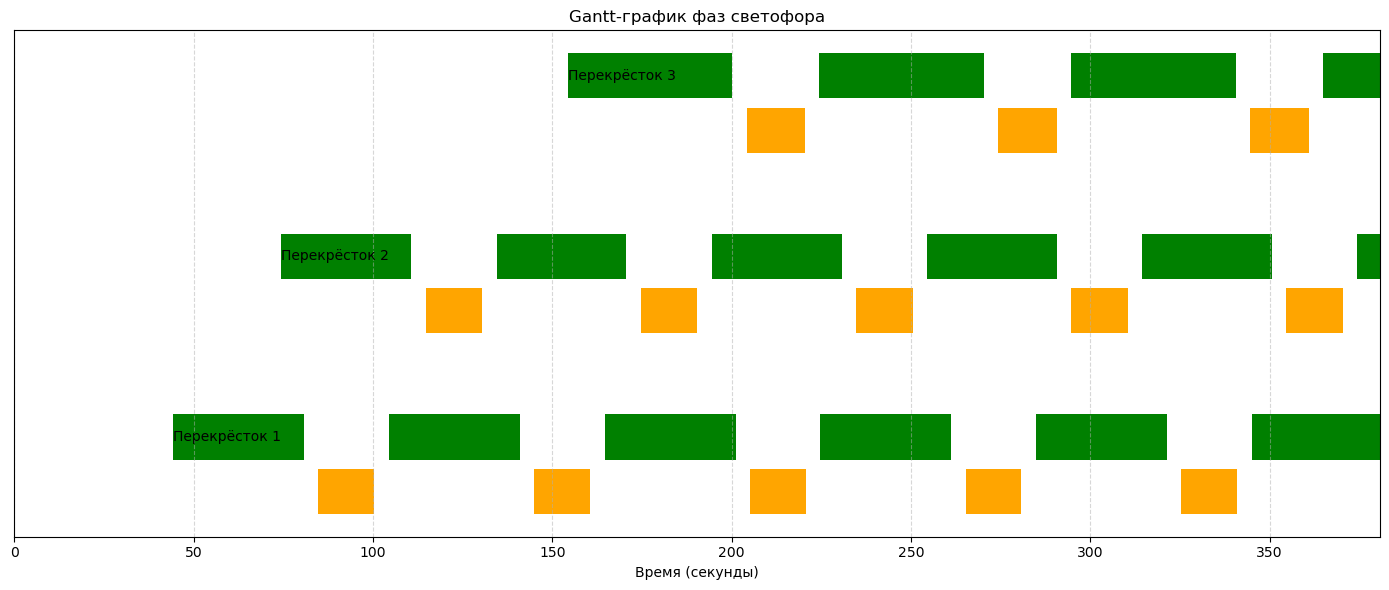

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json


signals_df = pd.read_csv("signals_current.csv")
with open("constraints.json") as f:
    constraints = json.load(f)
with open("best_solution.json") as f:
    best = json.load(f)

GENE_SIZE = 4
NUM_INTERSECTIONS = len(best) // GENE_SIZE

# План ПОСЛЕ оптимизации с abs_offset
plan_after = {}
time_accum = 0
for i in range(NUM_INTERSECTIONS):
    cycle = best[i * GENE_SIZE]
    main = best[i * GENE_SIZE + 1]
    sec = best[i * GENE_SIZE + 2]
    offset = best[i * GENE_SIZE + 3]
    abs_offset = time_accum + offset
    plan_after[i + 1] = {
        "cycle": cycle,
        "main": main,
        "sec": sec,
        "offset": offset,
        "abs_offset": abs_offset
    }
    time_accum += cycle

# === ВИЗУАЛИЗАЦИЯ ===
plot_duration = sum(p['cycle'] for p in plan_after.values()) * 2

fig, ax = plt.subplots(figsize=(14, 6))
colors = {"main": "green", "sec": "orange"}

for i, (inter_id, plan) in enumerate(plan_after.items(), start=1):
    y_main = i * 2
    y_sec = i * 2 - 0.6

    cycle = plan['cycle']
    main_dur = plan['main']
    sec_dur = plan['sec']
    lost_time = constraints['lost_time_sec_per_phase']
    abs_offset = plan['abs_offset']

    # Главная фаза (несколько повторов)
    k = 0
    while True:
        start = abs_offset + k * cycle
        if start > plot_duration:
            break
        ax.broken_barh([(start, main_dur)], (y_main, 0.5), facecolors=colors['main'])
        k += 1

    # Второстепенная фаза (несколько повторов)
    k = 0
    while True:
        start = abs_offset + main_dur + lost_time + k * cycle
        if start > plot_duration:
            break
        ax.broken_barh([(start, sec_dur)], (y_sec, 0.5), facecolors=colors['sec'])
        k += 1

    ax.text(abs_offset, y_main + 0.25, f"Перекрёсток {inter_id}", va="center")

ax.set_xlim(0, plot_duration)
ax.set_yticks([])
ax.set_xlabel("Время (секунды)")
ax.set_title("Gantt-график фаз светофора")
ax.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Генетический алгоритм без зеленой волны

In [19]:
import random
import numpy as np
import pandas as pd
from deap import base, creator, tools, algorithms
import json


flows = pd.read_csv("flows_peak.csv")
with open("constraints.json") as f:
    constraints = json.load(f)


NUM_INTERSECTIONS = 3
TRAVEL_TIME = 30  # секунд между перекрёстками
GENE_SIZE = 4  # [cycle, green_main, green_sec, offset]


def fitness(ind):
    total_delay = 0.0
    lost = 2 * constraints['lost_time_sec_per_phase']

    for i in range(NUM_INTERSECTIONS):
        base = i * GENE_SIZE
        cycle, g_main, g_sec, offset = ind[base:base+GENE_SIZE]

        if not (constraints['min_cycle_sec'] <= cycle <= constraints['max_cycle_sec']):
            return (1e9,)
        if g_main < constraints['min_green_sec'] or g_sec < constraints['min_green_sec']:
            return (1e9,)
        if g_main < constraints['pedestrian_green_sec'] or g_sec < constraints['pedestrian_green_sec']:
            return (1e9,)
        if g_main + g_sec + lost > cycle:
            return (1e9,)
        if not (0 <= offset <= cycle):
            return (1e9,)

        df = flows[flows.intersection_id == (i+1)]
        for _, row in df.iterrows():
            is_main = row.approach in ('N', 'S')
            flow = row.intensity_veh_per_hr
            bus_share = row.bus_share

            green = g_main if is_main else g_sec
            bonus = constraints['min_extra_green_sec']
            eff_green = min(cycle, green + bonus)
            weight = 1 + 2 * bus_share

            total_delay += (cycle - eff_green) * flow * weight

    # *** Без штрафа за зелёную волну ***
    return (total_delay, )

# === Инициализация DEAP ===
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()

# Создание случайного индивида
def create_individual():
    genes = []
    lost = 2 * constraints['lost_time_sec_per_phase']
    for _ in range(NUM_INTERSECTIONS):
        c = random.randint(constraints['min_cycle_sec'], constraints['max_cycle_sec'])
        while True:
            g1 = random.randint(constraints['min_green_sec'], c - constraints['min_green_sec'] - lost)
            g2 = random.randint(constraints['min_green_sec'], c - constraints['min_green_sec'] - lost)
            if g1 + g2 + lost <= c:
                break
        offset = random.randint(0, c)
        genes += [c, g1, g2, offset]
    return genes

toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", fitness)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=10, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# === Запуск оптимизации ===
def run():
    pop = toolbox.population(n=300)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    stats.register("avg", np.mean)

    algorithms.eaSimple(pop, toolbox,
                        cxpb=0.7, mutpb=0.3,
                        ngen=150, stats=stats,
                        halloffame=hof, verbose=True)

    best = hof[0]
    print("\n=== Лучшее решение ===")
    for i in range(NUM_INTERSECTIONS):
        b = i * GENE_SIZE
        c, g1, g2, off = best[b:b+GENE_SIZE]
        print(f"Перекрёсток {i+1}: Цикл={c:.2f}, главная={g1:.2f}, второстепенная={g2:.2f}, offset={off:.2f}")
    print(f"Фитнес (задержка): {fitness(best)[0]:,.2f}")

    with open("best_solution.json", "w") as f:
        json.dump(best, f)
    return best

# Подсчёт задержки автобусов по решению
def compute_bus_delay(solution):
    bus_delay = 0.0
    for i in range(NUM_INTERSECTIONS):
        base = i * GENE_SIZE
        cycle, g_main, g_sec, offset = solution[base:base+GENE_SIZE]
        df = flows[flows.intersection_id == (i+1)]
        for _, row in df.iterrows():
            is_main = row.approach in ('N', 'S')
            flow = row.intensity_veh_per_hr
            bus_share = row.bus_share
            flow_bus = flow * bus_share
            green = g_main if is_main else g_sec
            bonus = constraints['min_extra_green_sec']
            eff_green = min(cycle, green + bonus)

            delay = (cycle - eff_green) * flow_bus
            bus_delay += delay
    return bus_delay

if __name__ == "__main__":
    best_solution = run()
    bus_only_delay = compute_bus_delay(best_solution)
    print(f"Задержка по автобусным потокам: {bus_only_delay:,.2f} машино-секунд")


c:\Users\borze\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\borze\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	min   	avg   
0  	300   	372370	710386
1  	235   	372370	6.3688e+08
2  	240   	372370	7.40147e+08
3  	232   	373354	7.30166e+08
4  	222   	399139	7.40155e+08
5  	240   	399139	7.26828e+08
6  	241   	396879	7.30158e+08
7  	227   	387028	6.26876e+08
8  	228   	387004	5.83562e+08
9  	239   	342694	5.53571e+08
10 	220   	380012	4.66945e+08
11 	237   	353927	4.40283e+08
12 	249   	331046	4.86916e+08
13 	247   	353681	5.13573e+08
14 	240   	351041	4.73587e+08
15 	241   	353681	4.30271e+08
16 	241   	353681	4.30264e+08
17 	224   	338504	3.76943e+08
18 	231   	353681	4.50232e+08
19 	230   	328706	4.13578e+08
20 	227   	320470	4.46892e+08
21 	243   	313095	3.93578e+08
22 	225   	313765	4.0357e+08 
23 	247   	318525	3.70247e+08
24 	241   	302265	3.70243e+08
25 	241   	318442	3.90234e+08
26 	230   	318442	3.7357e+08 
27 	237   	316389	4.20216e+08
28 	237   	316389	4.70192e+08
29 	220   	316389	4.03551e+08
30 	226   	309941	3.36907e+08
31 	241   	309941	3.9355e+08 
32 	243   	312313	4.1

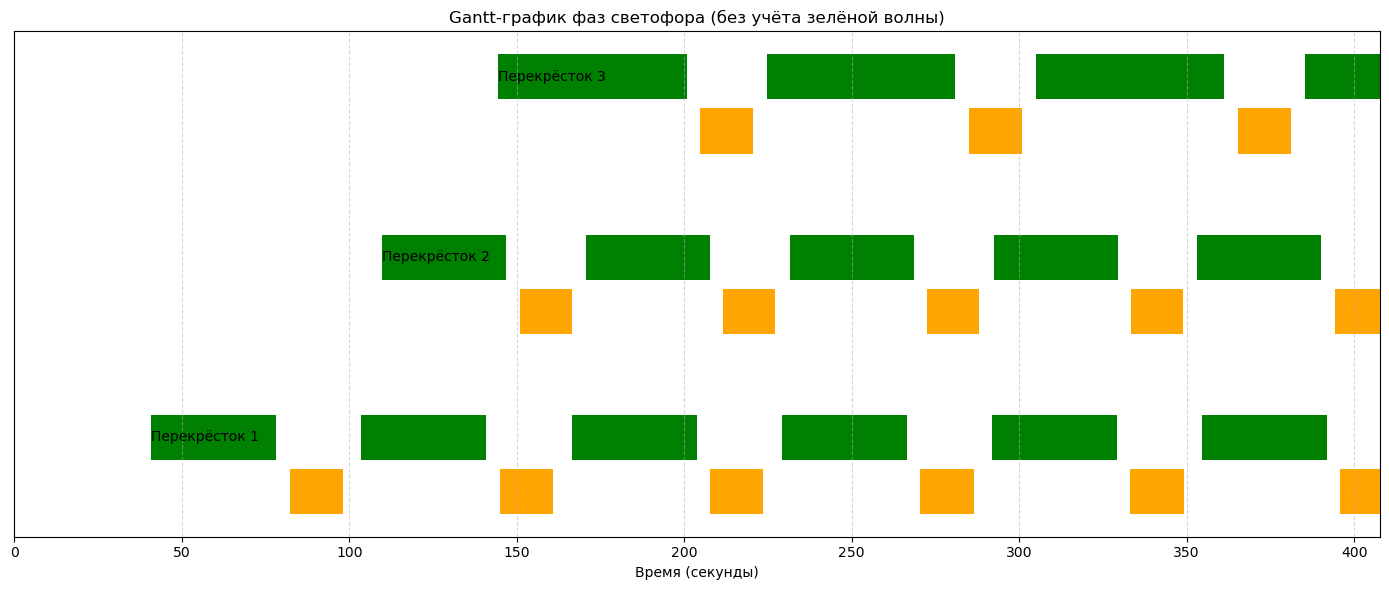

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json


signals_df = pd.read_csv("signals_current.csv")
with open("constraints.json") as f:
    constraints = json.load(f)
with open("best_solution.json") as f:
    best = json.load(f)

GENE_SIZE = 4
NUM_INTERSECTIONS = len(best) // GENE_SIZE

# План ДО оптимизации
plan_before = {
    int(row["intersection_id"]): {
        "cycle": row["cycle_sec"],
        "main": row["green_main_sec"],
        "sec": row["green_secondary_sec"]
    } for _, row in signals_df.iterrows()
}

# План ПОСЛЕ оптимизации с abs_offset
plan_after = {}
time_accum = 0
for i in range(NUM_INTERSECTIONS):
    cycle = best[i * GENE_SIZE]
    main = best[i * GENE_SIZE + 1]
    sec = best[i * GENE_SIZE + 2]
    # Если offset есть как параметр в solution:
    offset = best[i * GENE_SIZE + 3]
    abs_offset = time_accum + offset
    plan_after[i + 1] = {
        "cycle": cycle,
        "main": main,
        "sec": sec,
        "offset": offset,
        "abs_offset": abs_offset
    }
    time_accum += cycle

# Параметры
plot_duration = sum(p['cycle'] for p in plan_after.values()) * 2  # время отображения

fig, ax = plt.subplots(figsize=(14, 6))
colors = {"main": "green", "sec": "orange"}
TRAVEL_TIME = 30
# Вычисляем накопленное время (сумму циклов) для каждого перекрёстка
time_accumulated = 0
time_accums = []
for i in range(1, NUM_INTERSECTIONS + 1):
    if i == 1:
        time_accumulated = 0
    else:
        time_accumulated += plan_after[i - 1]['cycle']
    time_accums.append(time_accumulated)

for i, (inter_id, plan) in enumerate(plan_after.items(), start=1):
    y_main = i * 2
    y_sec = i * 2 - 0.6

    cycle = plan['cycle']
    main_dur = plan['main']
    sec_dur = plan['sec']
    lost_time = constraints['lost_time_sec_per_phase']
    abs_offset = plan['abs_offset']

    # Главная фаза
    k = 0
    while True:
        start = abs_offset + k * cycle
        if start > plot_duration:
            break
        ax.broken_barh([(start, main_dur)], (y_main, 0.5), facecolors=colors['main'])
        k += 1

    # Второстепенная фаза
    k = 0
    while True:
        start = abs_offset + main_dur + lost_time + k * cycle
        if start > plot_duration:
            break
        ax.broken_barh([(start, sec_dur)], (y_sec, 0.5), facecolors=colors['sec'])
        k += 1

    ax.text(abs_offset, y_main + 0.25, f"Перекрёсток {inter_id}", va="center")

# Всё остальное как есть:
ax.set_xlim(0, plot_duration)
ax.set_yticks([])
ax.set_xlabel("Время (секунды)")
ax.set_title("Gantt-график фаз светофора (без учёта зелёной волны)")
ax.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()




## Эвристический метод решения задачи (а правильный ли?)

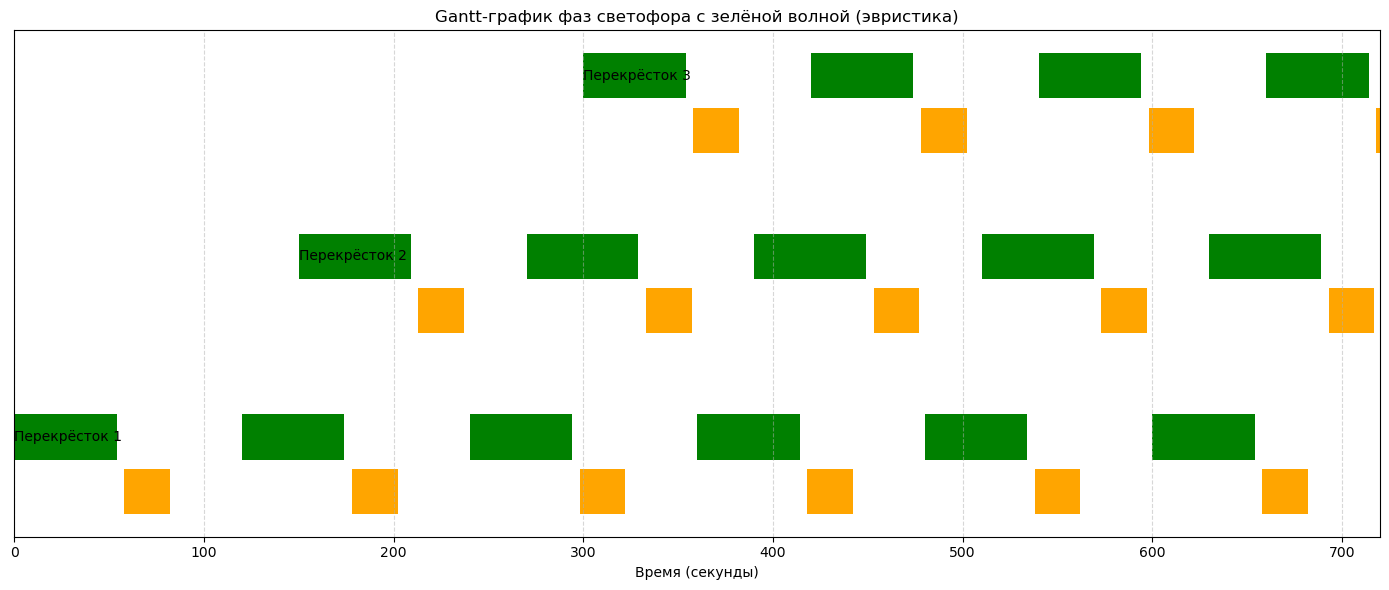

Общая задержка: 657,369.6 усл. ед.
Задержка автобусов: 35,059.8 машино-секунд
Задержка пешеходов (прибл.): 962.0 сек. (на всех перекрёстках за цикл)


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json

# Загрузка данных (файлы из твоего проекта)
signals_df = pd.read_csv("signals_current.csv")
with open("constraints.json") as f:
    constraints = json.load(f)
flows = pd.read_csv("flows_peak.csv")

NUM_INTERSECTIONS = 3
TRAVEL_TIME = 30  # секунд между перекрёстками
CYCLE = 120
LOST = 2 * constraints['lost_time_sec_per_phase']
PEDESTRIAN_MAIN = max(constraints['pedestrian_green_sec'], 20)
PEDESTRIAN_SEC = max(constraints['pedestrian_green_sec'], 10)

# Генерация эвристического решения
solution = []
plan_after = {}
time_accum = 0
for i in range(NUM_INTERSECTIONS):
    df = flows[flows.intersection_id == (i+1)]
    main_flow = df[df.approach.isin(['N','S'])]['intensity_veh_per_hr'].sum()
    sec_flow = df[df.approach.isin(['E','W'])]['intensity_veh_per_hr'].sum()
    main_bus_share = df[df.approach.isin(['N','S'])]['bus_share'].mean()

    if main_flow >= sec_flow:
        g_main = int(CYCLE * 0.45)
        g_sec = int(CYCLE * 0.20)
    else:
        g_main = int(CYCLE * 0.20)
        g_sec = int(CYCLE * 0.45)

    # Приоритет для автобусов
    if main_bus_share > 0.1:
        g_main += 5

    g_main = max(g_main, PEDESTRIAN_MAIN, constraints['min_green_sec'])
    g_sec = max(g_sec, PEDESTRIAN_SEC, constraints['min_green_sec'])

    # Не превышаем цикл
    if g_main + g_sec + LOST > CYCLE:
        diff = (g_main + g_sec + LOST) - CYCLE
        if g_sec - diff > PEDESTRIAN_SEC:
            g_sec -= diff
        else:
            g_main -= diff

    offset = (i * TRAVEL_TIME) % CYCLE
    solution.extend([CYCLE, g_main, g_sec, offset])

    abs_offset = time_accum + offset
    plan_after[i + 1] = {
        "cycle": CYCLE,
        "main": g_main,
        "sec": g_sec,
        "offset": offset,
        "abs_offset": abs_offset
    }
    time_accum += CYCLE

# Визуализация
plot_duration = sum(p['cycle'] for p in plan_after.values()) * 2

fig, ax = plt.subplots(figsize=(14, 6))
colors = {"main": "green", "sec": "orange"}

# Для расчёта зелёной волны
time_accumulated = 0
time_accums = []
for i in range(1, NUM_INTERSECTIONS + 1):
    if i == 1:
        time_accumulated = 0
    else:
        time_accumulated += plan_after[i - 1]['cycle']
    time_accums.append(time_accumulated)

for i, (inter_id, plan) in enumerate(plan_after.items(), start=1):
    y_main = i * 2
    y_sec = i * 2 - 0.6

    cycle = plan['cycle']
    main_dur = plan['main']
    sec_dur = plan['sec']
    lost_time = constraints['lost_time_sec_per_phase']
    abs_offset = plan['abs_offset']

    # Главная фаза (несколько повторов)
    k = 0
    while True:
        start = abs_offset + k * cycle
        if start > plot_duration:
            break
        ax.broken_barh([(start, main_dur)], (y_main, 0.5), facecolors=colors['main'])
        k += 1

    # Второстепенная фаза (несколько повторов)
    k = 0
    while True:
        start = abs_offset + main_dur + lost_time + k * cycle
        if start > plot_duration:
            break
        ax.broken_barh([(start, sec_dur)], (y_sec, 0.5), facecolors=colors['sec'])
        k += 1

    

    ax.text(abs_offset, y_main + 0.25, f"Перекрёсток {inter_id}", va="center")

ax.set_xlim(0, plot_duration)
ax.set_yticks([])
ax.set_xlabel("Время (секунды)")
ax.set_title("Gantt-график фаз светофора с зелёной волной (эвристика)")
ax.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
def analyze_delays(solution, flows, constraints, NUM_INTERSECTIONS, GENE_SIZE=4):
    total_delay = 0.0
    bus_delay = 0.0
    ped_delay = 0.0
    lost = 2 * constraints['lost_time_sec_per_phase']
    for i in range(NUM_INTERSECTIONS):
        base = i * GENE_SIZE
        cycle, g_main, g_sec, offset = solution[base:base+GENE_SIZE]
        df = flows[flows.intersection_id == (i+1)]
        for _, row in df.iterrows():
            is_main = row.approach in ('N', 'S')
            flow = row.intensity_veh_per_hr
            bus_share = row.bus_share
            flow_bus = flow * bus_share
            green = g_main if is_main else g_sec
            bonus = constraints['min_extra_green_sec']
            eff_green = min(cycle, green + bonus)
            weight = 1 + 2 * bus_share  # приоритет для автобусов

            total_delay += (cycle - eff_green) * flow * weight
            bus_delay += (cycle - eff_green) * flow_bus
            # Для пешеходов: задержка – разница между циклом и реально выделенным зелёным временем
            ped_required = constraints['pedestrian_green_sec']
            if green > ped_required:
                ped_delay += (cycle - green)  # суммируем лишнее ожидание, если фаза длиннее минимума

    return total_delay, bus_delay, ped_delay

# Вызов функции
total, buses, peds = analyze_delays(solution, flows, constraints, NUM_INTERSECTIONS)
print(f"Общая задержка: {total:,.1f} усл. ед.")
print(f"Задержка автобусов: {buses:,.1f} машино-секунд")
print(f"Задержка пешеходов (прибл.): {peds:,.1f} сек. (на всех перекрёстках за цикл)")

## Эвристический метод без зеленой волны

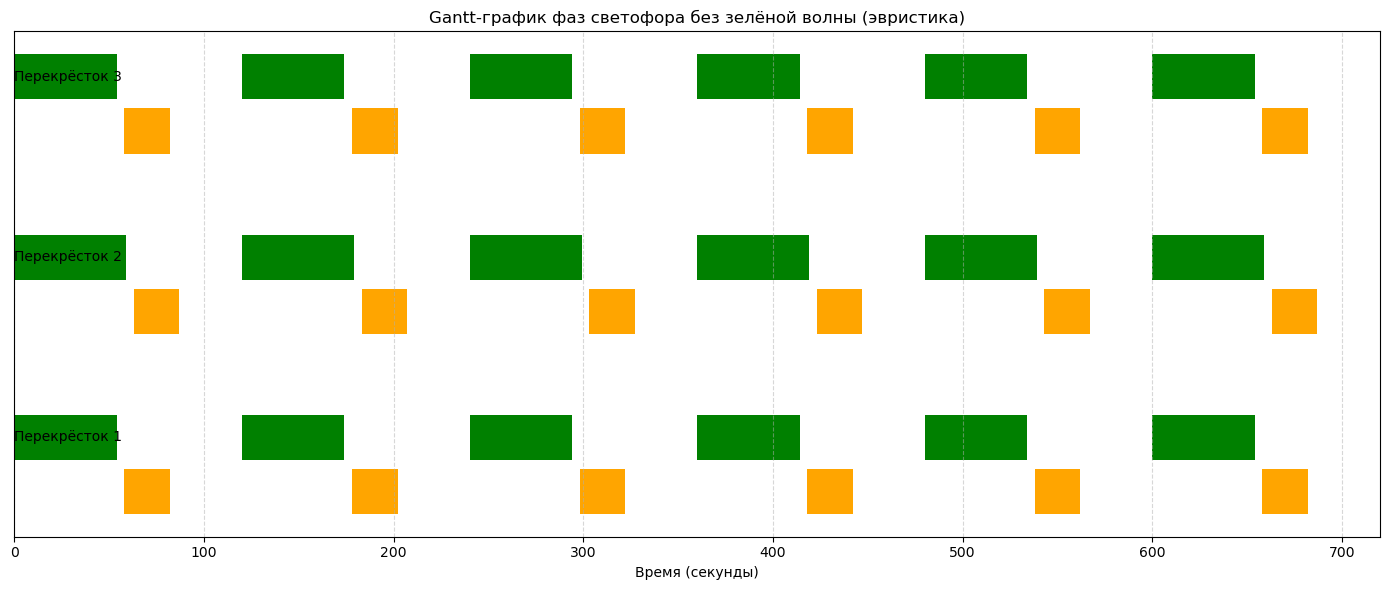

Общая задержка: 657,369.6 усл. ед.
Задержка автобусов: 35,059.8 машино-секунд
Задержка пешеходов (прибл.): 962.0 сек. (на всех перекрёстках за цикл)


In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json

# Загрузка данных
signals_df = pd.read_csv("signals_current.csv")
with open("constraints.json") as f:
    constraints = json.load(f)
flows = pd.read_csv("flows_peak.csv")

NUM_INTERSECTIONS = 3
CYCLE = 120
LOST = 2 * constraints['lost_time_sec_per_phase']
PEDESTRIAN_MAIN = max(constraints['pedestrian_green_sec'], 20)
PEDESTRIAN_SEC = max(constraints['pedestrian_green_sec'], 10)

# Генерация эвристического решения без координации/зеленой волны
solution = []
plan_after = {}
for i in range(NUM_INTERSECTIONS):
    df = flows[flows.intersection_id == (i+1)]
    main_flow = df[df.approach.isin(['N','S'])]['intensity_veh_per_hr'].sum()
    sec_flow = df[df.approach.isin(['E','W'])]['intensity_veh_per_hr'].sum()
    main_bus_share = df[df.approach.isin(['N','S'])]['bus_share'].mean()

    if main_flow >= sec_flow:
        g_main = int(CYCLE * 0.45)
        g_sec = int(CYCLE * 0.20)
    else:
        g_main = int(CYCLE * 0.20)
        g_sec = int(CYCLE * 0.45)

    # Приоритет для автобусов
    if main_bus_share > 0.1:
        g_main += 5

    g_main = max(g_main, PEDESTRIAN_MAIN, constraints['min_green_sec'])
    g_sec = max(g_sec, PEDESTRIAN_SEC, constraints['min_green_sec'])

    # Не превышаем цикл
    if g_main + g_sec + LOST > CYCLE:
        diff = (g_main + g_sec + LOST) - CYCLE
        if g_sec - diff > PEDESTRIAN_SEC:
            g_sec -= diff
        else:
            g_main -= diff

    offset = 0  # Все стартуют одновременно, чтобы не было волны
    solution.extend([CYCLE, g_main, g_sec, offset])

    plan_after[i + 1] = {
        "cycle": CYCLE,
        "main": g_main,
        "sec": g_sec,
        "offset": offset,
        "abs_offset": offset
    }

# Визуализация
plot_duration = sum(p['cycle'] for p in plan_after.values()) * 2

fig, ax = plt.subplots(figsize=(14, 6))
colors = {"main": "green", "sec": "orange"}

for i, (inter_id, plan) in enumerate(plan_after.items(), start=1):
    y_main = i * 2
    y_sec = i * 2 - 0.6

    cycle = plan['cycle']
    main_dur = plan['main']
    sec_dur = plan['sec']
    lost_time = constraints['lost_time_sec_per_phase']
    abs_offset = plan['abs_offset']

    # Главная фаза (несколько повторов)
    k = 0
    while True:
        start = abs_offset + k * cycle
        if start > plot_duration:
            break
        ax.broken_barh([(start, main_dur)], (y_main, 0.5), facecolors=colors['main'])
        k += 1

    # Второстепенная фаза (несколько повторов)
    k = 0
    while True:
        start = abs_offset + main_dur + lost_time + k * cycle
        if start > plot_duration:
            break
        ax.broken_barh([(start, sec_dur)], (y_sec, 0.5), facecolors=colors['sec'])
        k += 1

    ax.text(abs_offset, y_main + 0.25, f"Перекрёсток {inter_id}", va="center")

ax.set_xlim(0, plot_duration)
ax.set_yticks([])
ax.set_xlabel("Время (секунды)")
ax.set_title("Gantt-график фаз светофора без зелёной волны (эвристика)")
ax.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# Анализ задержек для эвристического решения
def analyze_delays(solution, flows, constraints, NUM_INTERSECTIONS, GENE_SIZE=4):
    total_delay = 0.0
    bus_delay = 0.0
    ped_delay = 0.0
    lost = 2 * constraints['lost_time_sec_per_phase']
    for i in range(NUM_INTERSECTIONS):
        base = i * GENE_SIZE
        cycle, g_main, g_sec, offset = solution[base:base+GENE_SIZE]
        df = flows[flows.intersection_id == (i+1)]
        for _, row in df.iterrows():
            is_main = row.approach in ('N', 'S')
            flow = row.intensity_veh_per_hr
            bus_share = row.bus_share
            flow_bus = flow * bus_share
            green = g_main if is_main else g_sec
            bonus = constraints['min_extra_green_sec']
            eff_green = min(cycle, green + bonus)
            weight = 1 + 2 * bus_share  # приоритет для автобусов

            total_delay += (cycle - eff_green) * flow * weight
            bus_delay += (cycle - eff_green) * flow_bus
            # Для пешеходов: задержка – разница между циклом и реально выделенным зелёным временем
            ped_required = constraints['pedestrian_green_sec']
            if green > ped_required:
                ped_delay += (cycle - green)  # суммируем лишнее ожидание, если фаза длиннее минимума

    return total_delay, bus_delay, ped_delay

# Вызов функции
total, buses, peds = analyze_delays(solution, flows, constraints, NUM_INTERSECTIONS)
print(f"Общая задержка: {total:,.1f} усл. ед.")
print(f"Задержка автобусов: {buses:,.1f} машино-секунд")
print(f"Задержка пешеходов (прибл.): {peds:,.1f} сек. (на всех перекрёстках за цикл)")

## Линейный способ решения задачи

In [23]:
import pandas as pd
import json
import pulp

# === Данные ===
signals_df = pd.read_csv("signals_current.csv")
flows_df = pd.read_csv("flows_peak.csv")
with open("constraints.json") as f:
    constraints = json.load(f)

NUM_INTERSECTIONS = signals_df.shape[0]
lost_time = 2 * constraints["lost_time_sec_per_phase"]

# === Модель ===
model = pulp.LpProblem("TrafficLightOptimization", pulp.LpMinimize)

# === Переменные для каждого перекрёстка ===
green_main = {i+1: pulp.LpVariable(f"green_main_{i+1}", lowBound=constraints["min_green_sec"], upBound=signals_df.iloc[i]["cycle_sec"]-constraints["min_green_sec"]-lost_time, cat='Integer') for i in range(NUM_INTERSECTIONS)}
green_sec = {i+1: pulp.LpVariable(f"green_sec_{i+1}", lowBound=constraints["min_green_sec"], upBound=signals_df.iloc[i]["cycle_sec"]-constraints["min_green_sec"]-lost_time, cat='Integer') for i in range(NUM_INTERSECTIONS)}

# === Ограничения по фазам ===
for i in range(1, NUM_INTERSECTIONS+1):
    cycle = signals_df.loc[signals_df['intersection_id'] == i, 'cycle_sec'].values[0]
    model += green_main[i] + green_sec[i] + lost_time <= cycle
    model += green_main[i] >= constraints['min_green_sec']
    model += green_sec[i] >= constraints['min_green_sec']
    model += green_main[i] >= constraints['pedestrian_green_sec']  # для главной

# === Целевая функция (минимизация задержки) ===
total_delay = []
for inter_id in range(1, NUM_INTERSECTIONS+1):
    cycle = signals_df.loc[signals_df['intersection_id'] == inter_id, 'cycle_sec'].values[0]
    df = flows_df[flows_df["intersection_id"] == inter_id]
    for _, row in df.iterrows():
        is_main = row["approach"] in ["N", "S"]
        flow = row["intensity_veh_per_hr"]
        bus_share = row["bus_share"]
        green = green_main[inter_id] if is_main else green_sec[inter_id]
        weight = 1 + 2 * bus_share
        total_delay.append((cycle - green) * flow * weight)

model += pulp.lpSum(total_delay)

# === Решение ===
solver = pulp.PULP_CBC_CMD(msg=True)
model.solve(solver)

# === Вывод ===
print("Status:", pulp.LpStatus[model.status])
for i in range(1, NUM_INTERSECTIONS+1):
    print(f"Перекрёсток {i}: Главная {green_main[i].varValue:.0f} сек, Второстепенная {green_sec[i].varValue:.0f} сек")
print(f"Суммарная задержка: {pulp.value(model.objective):,.2f} машино-секунд")

Status: Optimal
Перекрёсток 1: Главная 97 сек, Второстепенная 15 сек
Перекрёсток 2: Главная 97 сек, Второстепенная 15 сек
Перекрёсток 3: Главная 97 сек, Второстепенная 15 сек
Суммарная задержка: 449,333.00 машино-секунд


## Муравьиная колония (еще один метаэвристический подход)

In [24]:
import numpy as np
import pandas as pd
import random
import json
from collections import defaultdict

# Загрузка данных
flows = pd.read_csv("flows_peak.csv")
with open("constraints.json") as f:
    constraints = json.load(f)

NUM_INTERSECTIONS = 3
GENE_SIZE = 4
TRAVEL_TIME = 30

In [25]:
pheromones = defaultdict(lambda: 1.0)  # феромон по умолчанию
EVAPORATION = 0.1
ALPHA = 1.0  # важность феромонов
BETA = 2.0   # важность эвристики
NUM_ANTS = 50
NUM_GENERATIONS = 100

In [26]:
def generate_ant_solution():
    solution = []
    lost = 2 * constraints['lost_time_sec_per_phase']
    for inter in range(NUM_INTERSECTIONS):
        c = random.randint(constraints['min_cycle_sec'], constraints['max_cycle_sec'])

        # Выбор зелёных фаз с эвристикой
        options = []
        for g1 in range(constraints['min_green_sec'], c - constraints['min_green_sec'] - lost + 1):
            for g2 in range(constraints['min_green_sec'], c - g1 - lost + 1):
                if g1 + g2 + lost <= c:
                    heuristic = g1 + g2  # или более сложная эвристика
                    pher = pheromones[(inter, g1, g2)]
                    prob = (pher ** ALPHA) * (heuristic ** BETA)
                    options.append((g1, g2, prob))

        if not options:
            return None

        g1, g2 = random.choices(
            population=[(g1, g2) for g1, g2, _ in options],
            weights=[p for _, _, p in options],
            k=1
        )[0]

        offset = random.randint(0, c)
        solution.extend([c, g1, g2, offset])
    return solution

In [27]:
def fitness(ind):
    total_delay = 0.0
    lost = 2 * constraints['lost_time_sec_per_phase']

    for i in range(NUM_INTERSECTIONS):
        base = i * GENE_SIZE
        cycle, g_main, g_sec, offset = ind[base:base+GENE_SIZE]

        # Проверка ограничений
        if not (constraints['min_cycle_sec'] <= cycle <= constraints['max_cycle_sec']):
            return (1e9,)
        if g_main < constraints['min_green_sec'] or g_sec < constraints['min_green_sec']:
            return (1e9,)
        if g_main < constraints['pedestrian_green_sec'] or g_sec < constraints['pedestrian_green_sec']:
            return (1e9,)
        if g_main + g_sec + lost > cycle:
            return (1e9,)
        if not (0 <= offset <= cycle):
            return (1e9,)

        # Задержка по всем потокам с приоритетом автобусов
        df = flows[flows.intersection_id == (i+1)]
        for _, row in df.iterrows():
            is_main = row.approach in ('N', 'S')
            flow = row.intensity_veh_per_hr
            bus_share = row.bus_share

            green = g_main if is_main else g_sec
            bonus = constraints['min_extra_green_sec']
            eff_green = min(cycle, green + bonus)
            weight = 1 + 2 * bus_share

            total_delay += (cycle - eff_green) * flow * weight

    # Координация (зелёная волна) с умеренным штрафом
    # Зелёная волна — точный расчёт
    penalty = 0.0
    offset_prev = ind[3]  # offset первого перекрёстка
    for i in range(1, NUM_INTERSECTIONS):
        cycle_curr = ind[i * GENE_SIZE]
        offset_curr = ind[i * GENE_SIZE + 3]
        # Ожидаемое начало: смещение предыдущего + travel_time, но всегда в пределах текущего цикла
        expected = (offset_prev + TRAVEL_TIME) % cycle_curr
        diff = abs(offset_curr - expected)
        penalty += min(diff, cycle_curr - diff)
        offset_prev = offset_curr



    return (total_delay + 100* penalty,)

In [28]:
def evaluate(solution):
    if solution is None:
        return 1e9
    return fitness(solution)[0]

In [29]:
best_solution = None
best_score = float('inf')

for gen in range(NUM_GENERATIONS):
    ants = [generate_ant_solution() for _ in range(NUM_ANTS)]
    scores = [evaluate(a) for a in ants]

    for ant, score in zip(ants, scores):
        if score < best_score:
            best_score = score
            best_solution = ant

    # Обновление феромонов
    for inter in range(NUM_INTERSECTIONS):
        for g1 in range(constraints['min_green_sec'], 61):
            for g2 in range(constraints['min_green_sec'], 61):
                pheromones[(inter, g1, g2)] *= (1 - EVAPORATION)

    for ant, score in zip(ants, scores):
        if ant is None:
            continue
        for inter in range(NUM_INTERSECTIONS):
            idx = inter * GENE_SIZE
            _, g1, g2, _ = ant[idx:idx+GENE_SIZE]
            pheromones[(inter, g1, g2)] += 1.0 / (score + 1e-6)  # усиление

with open("best_solution.json", "w") as f:
    json.dump(best_solution, f)

def compute_bus_delay(solution):
    bus_delay = 0.0
    for i in range(NUM_INTERSECTIONS):
        base = i * GENE_SIZE
        cycle, g_main, g_sec, offset = solution[base:base+GENE_SIZE]
        df = flows[flows.intersection_id == (i+1)]
        for _, row in df.iterrows():
            is_main = row.approach in ('N', 'S')
            flow = row.intensity_veh_per_hr
            bus_share = row.bus_share
            flow_bus = flow * bus_share

            green = g_main if is_main else g_sec
            bonus = constraints['min_extra_green_sec']
            eff_green = min(cycle, green + bonus)

            delay = (cycle - eff_green) * flow_bus
            bus_delay += delay
    return bus_delay


bus_only_delay = compute_bus_delay(best_solution)
print(f"Задержка по автобусным потокам: {bus_only_delay:,.2f} машино-секунд")


Задержка по автобусным потокам: 15,353.50 машино-секунд
